## 📋 Project Overview

This project focuses on classifying pulsar stars using the HTRU2 dataset from Kaggle. Pulsars are rare and valuable astronomical objects, and accurate classification is crucial for astronomical research. The project implements a complete machine learning pipeline from data acquisition to model deployment.

### 🎯 Business Problem

Pulsars are rare neutron stars that produce valuable scientific data. Manual classification is time-consuming and prone to error. This project aims to automate pulsar classification using machine learning to assist astronomers in identifying genuine pulsar signals from noise.

### 📊 Dataset

- **Source**: [HTRU2 Dataset from Kaggle](https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2)
- **Samples**: 17,898 total instances
- **Features**: 8 numerical features derived from pulsar candidate profiles
- **Target**: Binary classification (0 = non-pulsar, 1 = pulsar)
- **Class Distribution**: Highly imbalanced (~90.84% non-pulsars, ~9.16% pulsars)

### Dataset Features

The HTRU2 dataset contains 8 features derived from the integrated pulse profile and DM-SNR curve:

1. **Integrated Profile Features**:
   - `ip_mean`: Mean of the integrated profile
   - `ip_std`: Standard deviation of the integrated profile
   - `ip_kurtosis`: Kurtosis of the integrated profile
   - `ip_skewness`: Skewness of the integrated profile

2. **DM-SNR Curve Features**:
   - `dm_mean`: Mean of the DM-SNR curve
   - `dm_std`: Standard deviation of the DM-SNR curve
   - `dm_kurtosis`: Kurtosis of the DM-SNR curve
   - `dm_skewness`: Skewness of the DM-SNR curve

3. **Target**:
   - `signal`: Class label (0: noise, 1: pulsar)

Check out full project: [GitHub Project](https://github.com/mchadolias/pulsar-classification)

If you have any comments, or contributions don't hesitate to post them!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Filter out the specific warning
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*length-1 list-like.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*get_group.*")

COLUMN_NAMES = [
    "ip_mean",
    "ip_std",
    "ip_kurtosis",
    "ip_skewness",
    "dm_mean",
    "dm_std",
    "dm_kurtosis",
    "dm_skewness",
    "signal",
]

### Import Dataset

In [2]:
# import daataset
df= pd.read_csv("/kaggle/input/pulsar-dataset-htru2/HTRU_2.csv")

In [3]:
# Add proper values to the columns
df.columns = COLUMN_NAMES

In [4]:
df = df.replace([np.inf, -np.inf], np.nan)

In [5]:
df.dtypes

ip_mean        float64
ip_std         float64
ip_kurtosis    float64
ip_skewness    float64
dm_mean        float64
dm_std         float64
dm_kurtosis    float64
dm_skewness    float64
signal           int64
dtype: object

In [6]:
df.head()

,ip_mean,ip_std,ip_kurtosis,ip_skewness,dm_mean,dm_std,dm_kurtosis,dm_skewness,signal
0,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
1,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
2,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
3,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
4,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0


In [7]:
df.isna().sum()

ip_mean        0
ip_std         0
ip_kurtosis    0
ip_skewness    0
dm_mean        0
dm_std         0
dm_kurtosis    0
dm_skewness    0
signal         0
dtype: int64

In [8]:
print("Number of missing values:", df.isnull().sum().sum())

Number of missing values: 0


In [9]:
print("Number of duplicated values:", df.duplicated().sum())

Number of duplicated values: 0


In [10]:
df.describe()

,ip_mean,ip_std,ip_kurtosis,ip_skewness,dm_mean,dm_std,dm_kurtosis,dm_skewness,signal
count,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.00000
mean,111.078321,46.549021,0.477897,1.770417,12.614926,26.326918,8.303574,104.859419,0.09158
std,25.652705,6.843040,1.064056,6.168058,29.473637,19.471042,4.506217,106.517270,0.28844
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.00000
25%,100.929688,42.375426,0.027108,-0.188528,1.923077,14.437330,5.781485,34.957119,0.00000
50%,115.078125,46.946435,0.223241,0.198736,2.801839,18.459977,8.433872,83.068996,0.00000
75%,127.085938,51.022887,0.473349,0.928206,5.464883,28.428152,10.702973,139.310905,0.00000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.00000


### Explore Dataset

Maximum correlation values:
ip_mean: 0.55
ip_std: 0.55
ip_kurtosis: 0.95
ip_skewness: 0.95
dm_mean: 0.80
dm_std: 0.80
dm_kurtosis: 0.92
dm_skewness: 0.92
signal: 0.79


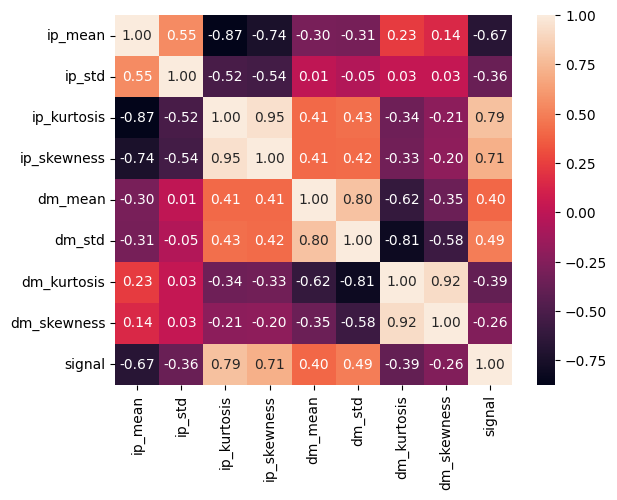

In [11]:
    corr = df.corr()

    sns.heatmap(corr, annot=True, fmt=".2f")

    # Print the max correlation values
    print("Maximum correlation values:")
    for col in corr.columns:
        max_corr = corr[col][corr[col] != 1.0].max()
        print(f"{col}: {max_corr:.2f}")

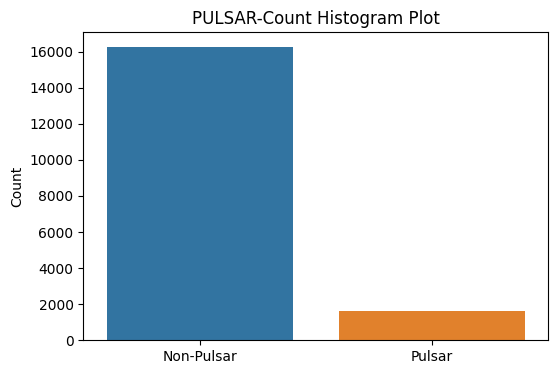

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df, x= "signal",  ax=ax)
ax.set(xlabel="", ylabel='Count', title='PULSAR-Count Histogram Plot')
ax.xaxis.set_ticklabels(['Non-Pulsar', 'Pulsar']);


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


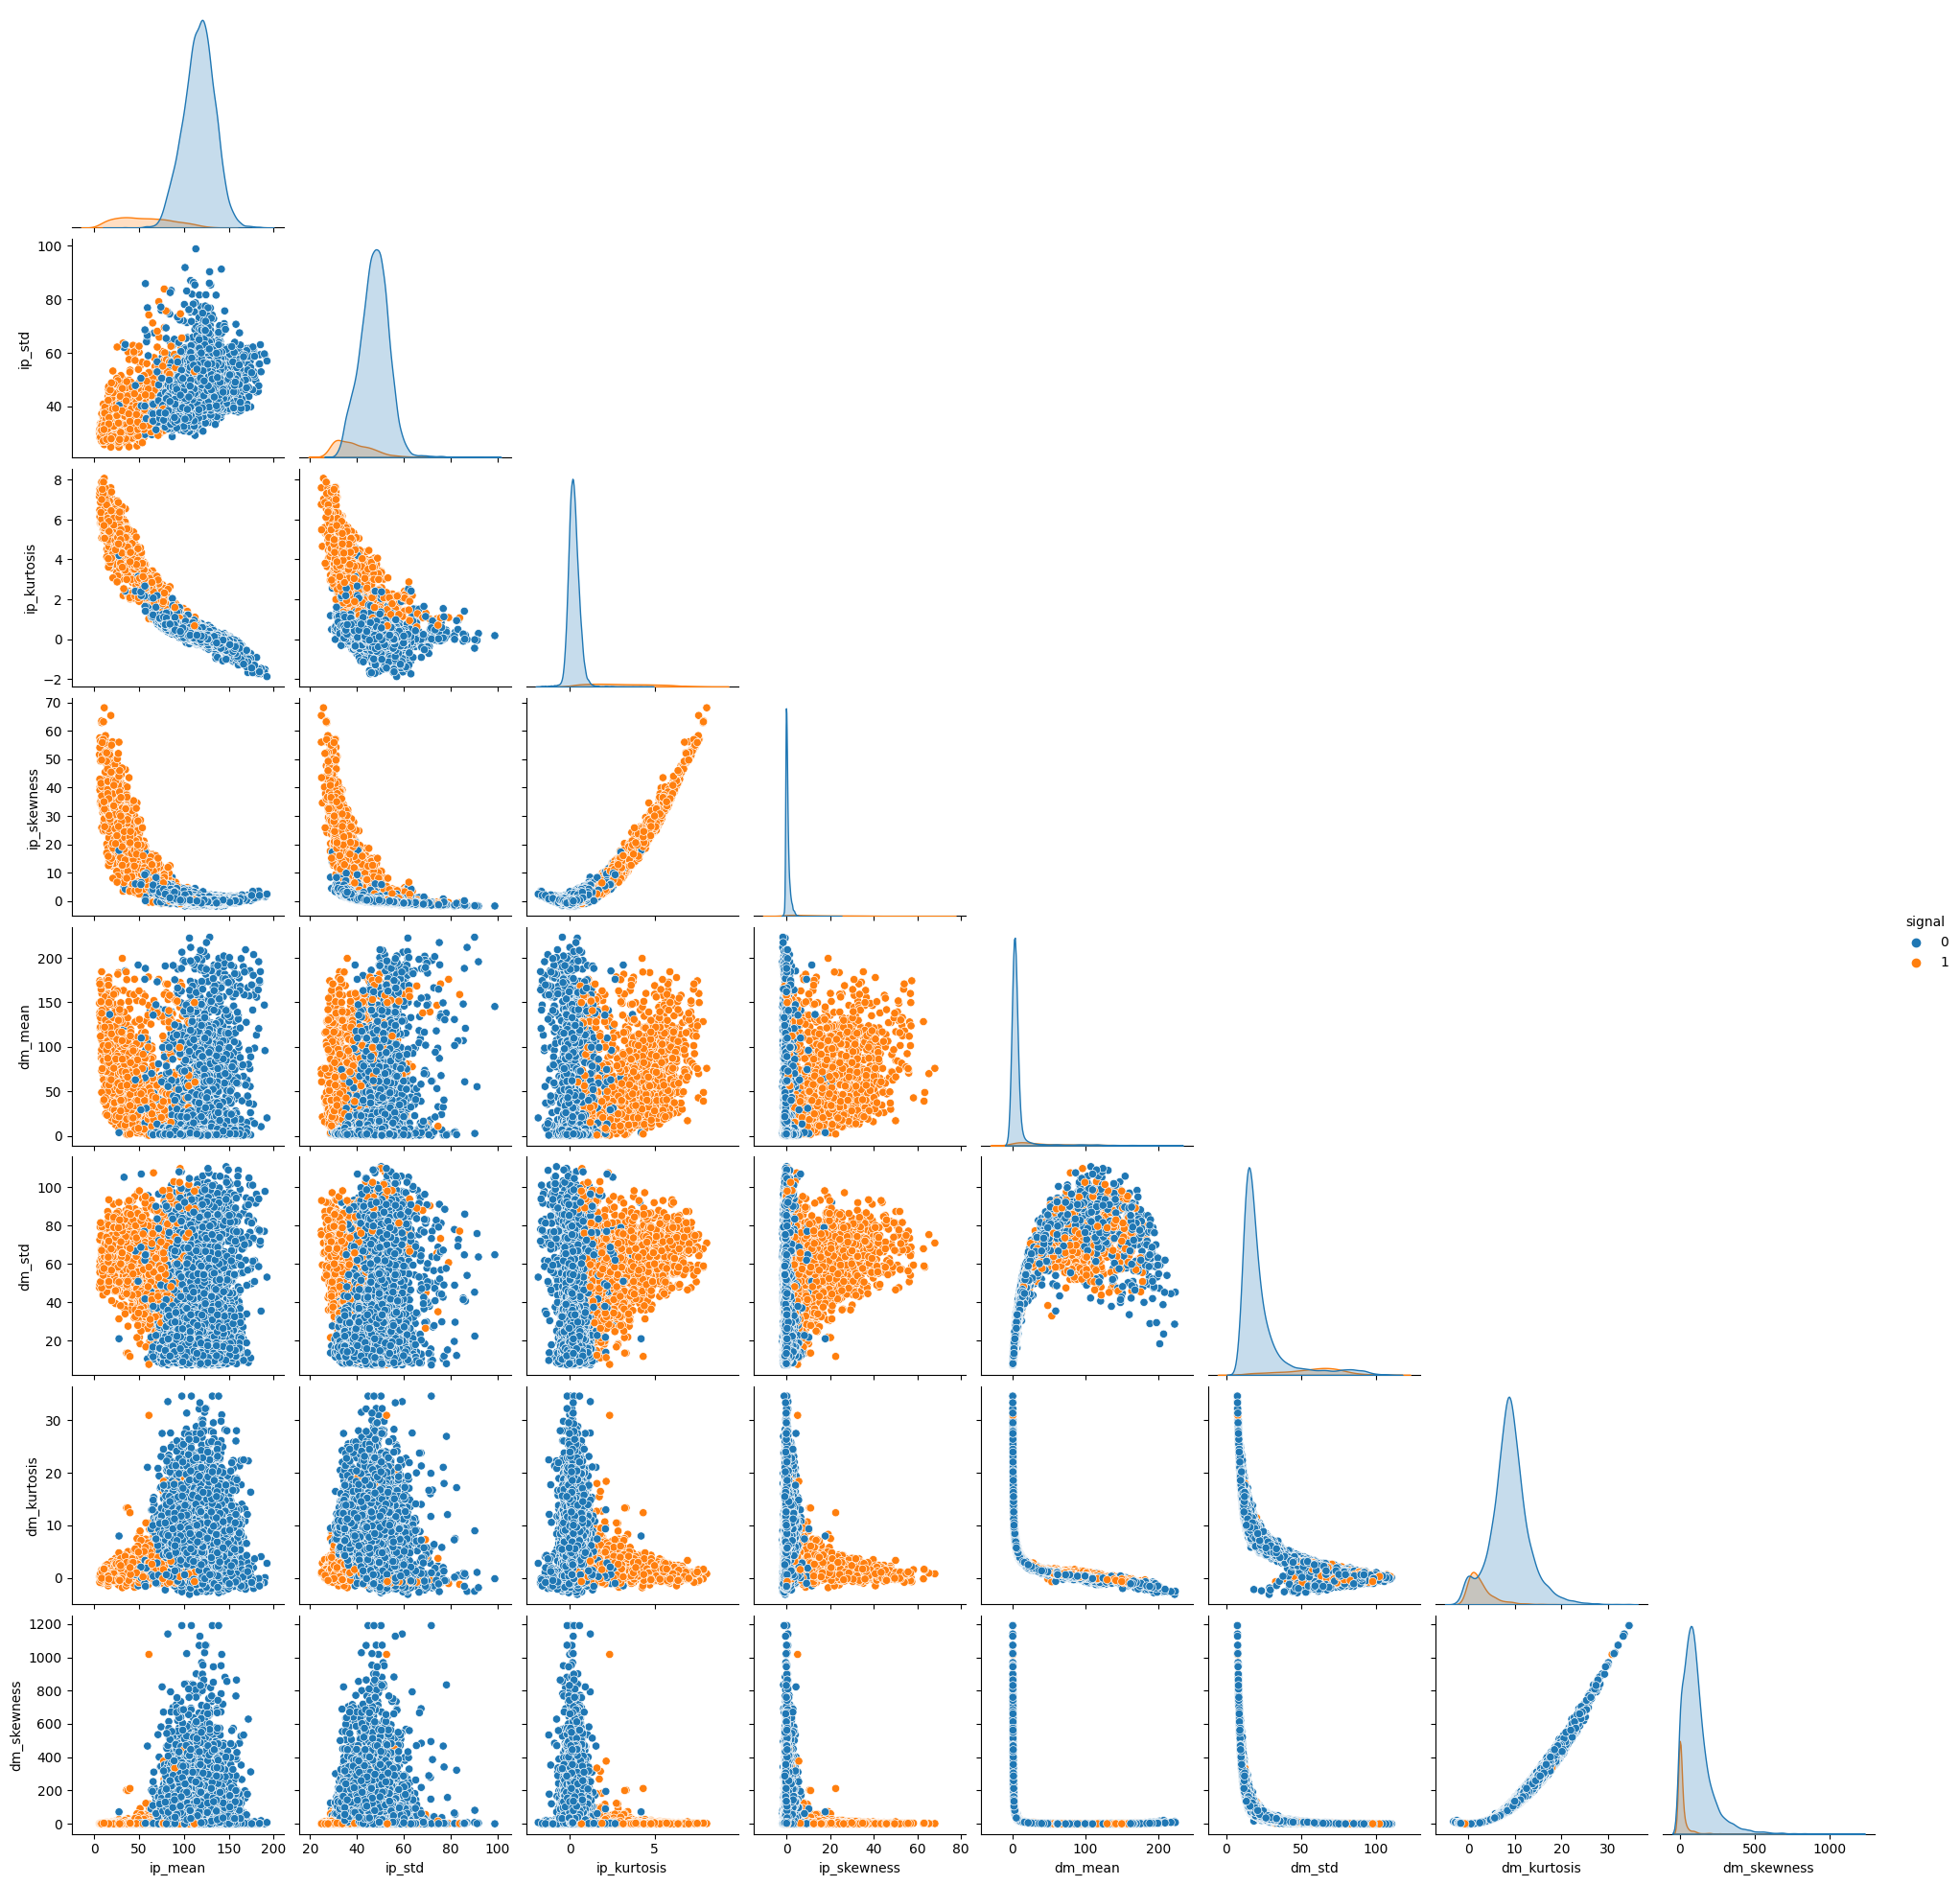

In [13]:
sns.pairplot(df, hue='signal', corner=True);

In [14]:
def create_violin_boxplot_combo(df, figsize=(18, 14)):
    """
    Create violin plots with embedded boxplots for better distribution visualization
    """
    n_cols = len(df.columns)
    n_rows = (n_cols + 2) // 4  
    
    fig, axes = plt.subplots(n_rows, 4, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for i, column in enumerate(df.columns):
        if column == "signal":
            return
            
        if i < len(axes):
            data = df[column].dropna()
            
            # Create violin plot with embedded boxplot
            sns.violinplot(y=data, ax=axes[i], inner='box', palette='pastel')
            
            # Add summary statistics
            stats_text = f"""
            N: {len(data):,}
            Mean: {data.mean():.2f}
            Std: {data.std():.2f}
            Min: {data.min():.2f}
            Max: {data.max():.2f}
            """
            
            axes[i].set_title(f'{column}', fontweight='bold', fontsize=12)
            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                       fontsize=8, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide empty subplots
    for i in range(len(df.columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Detailed Distribution Analysis', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def create_horizontal_boxplot_with_density(df, figsize=(12, 25), palette="Set2"):
    """
    Create horizontal boxplots with distribution density plots
    """
    columns_to_plot = df.columns[(df.columns != "signal")].tolist()

    n_cols = len(columns_to_plot)
    
    fig, axes = plt.subplots(n_cols, 1, figsize=figsize)
    
    if n_cols == 1:
        axes = [axes]

    for i, column in enumerate(columns_to_plot):
        data = df[column].dropna()
        
        # Create horizontal boxplot
        sns.boxplot(x=data, ax=axes[i], color=sns.color_palette(palette)[i % len(sns.color_palette(palette))],
                   width=1, fliersize=4)
        
        # Create a twin axis for the density plot
        ax2 = axes[i].twinx()
        
        # Plot distribution density
        sns.kdeplot(data=data, ax=ax2, color='darkblue', alpha=0.5, linewidth=2)
        ax2.set_ylabel('Density', fontsize=10)
        ax2.grid(False)  # Remove grid from density plot
        
        # Style the main plot
        axes[i].set_title(f'{column}', fontweight='bold', fontsize=13)
        axes[i].set_ylabel('')
        
        # Add statistical information
        stats_text = f'Mean: {data.mean():.2f} | Median: {data.median():.2f} | Std: {data.std():.2f}'
        axes[i].text(0.7, 0.9, stats_text, transform=axes[i].transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add sample size
        axes[i].text(0.7, 0.75, f'N = {len(data):,}', transform=axes[i].transAxes,
                   fontsize=9, verticalalignment='top')
    plt.tight_layout()
    plt.show()

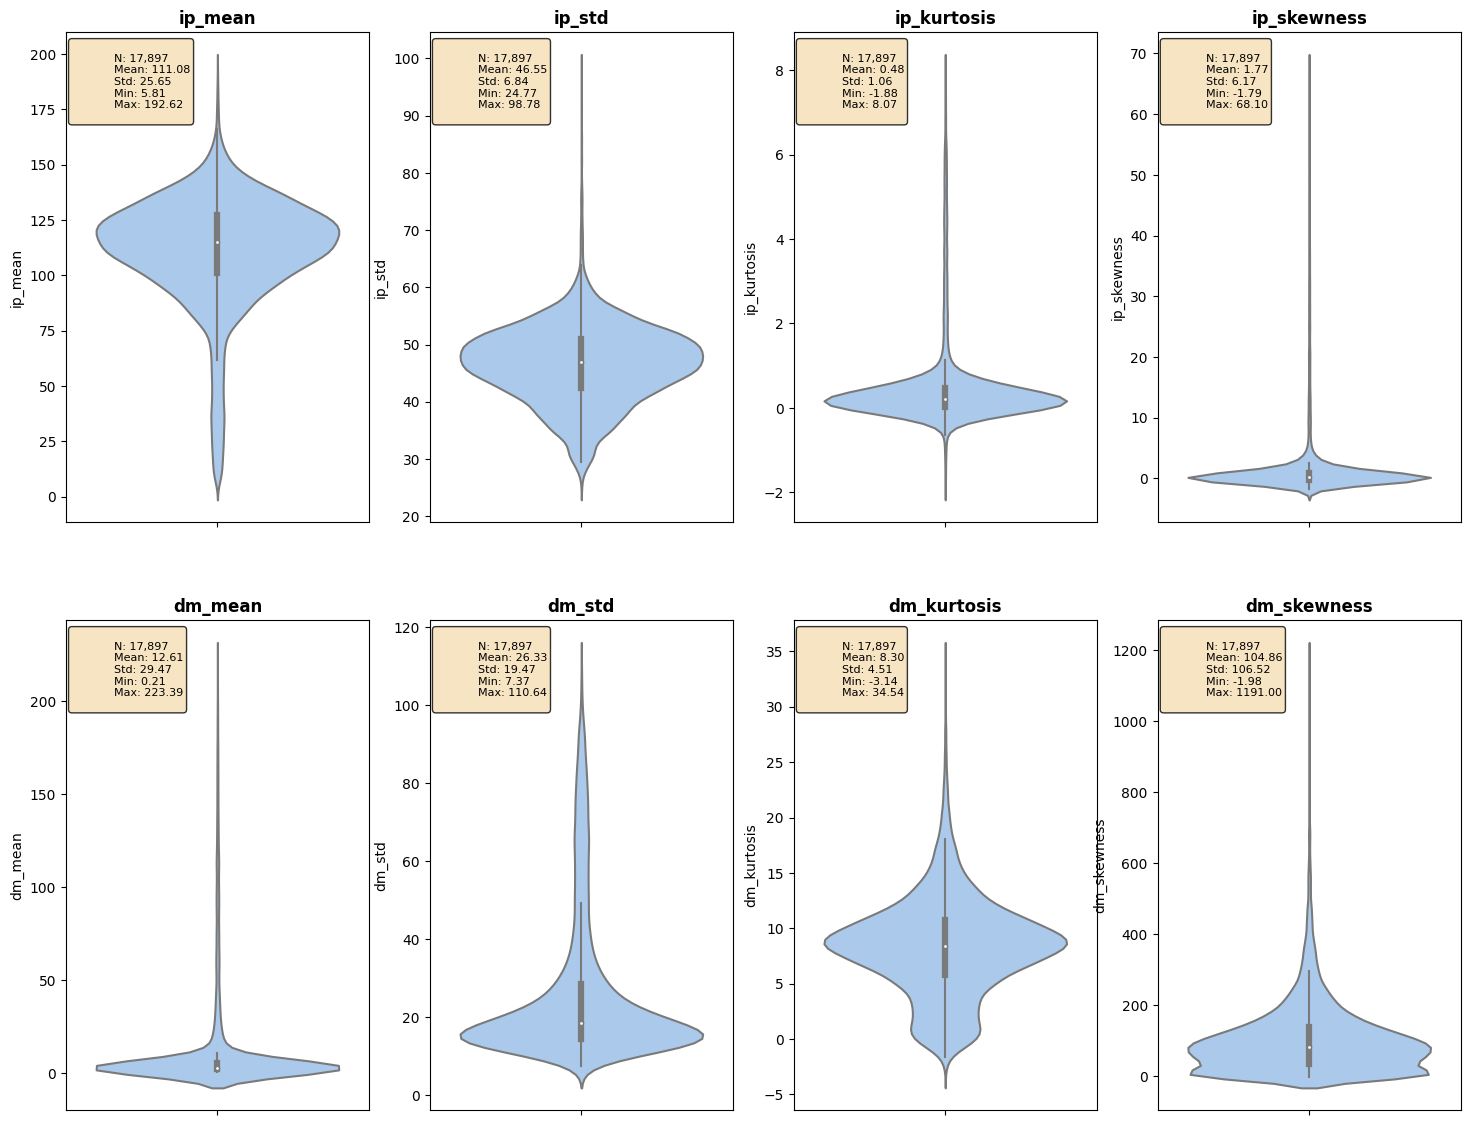

In [15]:
create_violin_boxplot_combo(df)

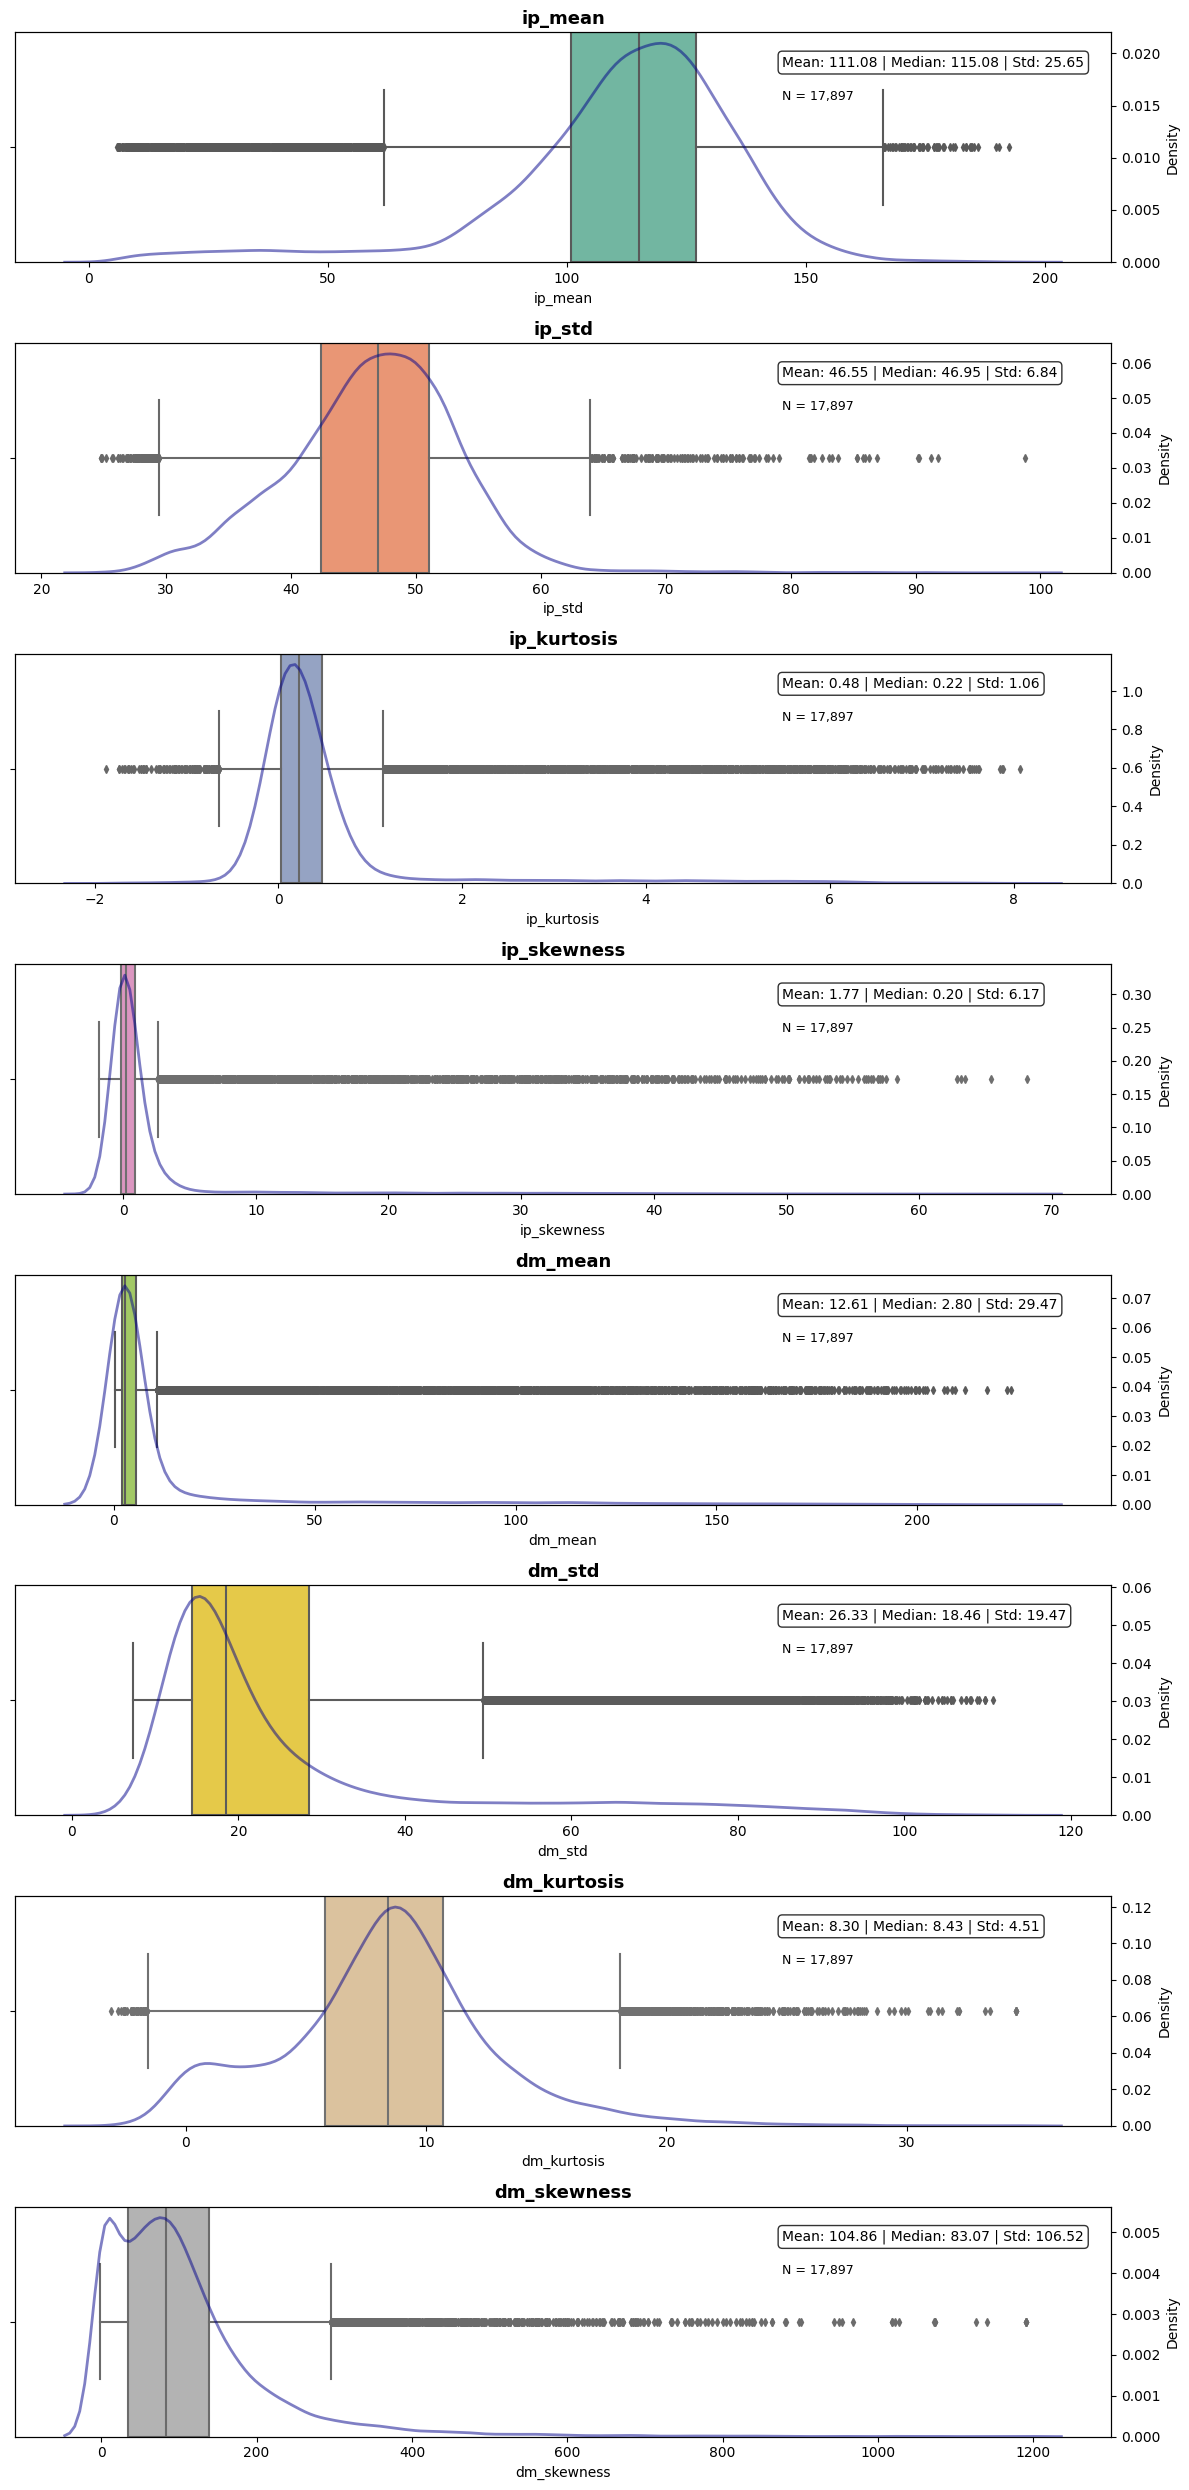

In [16]:
create_horizontal_boxplot_with_density(df)

#### Model Training

In [17]:
X = df.drop('signal', axis=1)  # Features
y = df['signal']

In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
# Scale the features for better model performance
scaler = StandardScaler()

# Fit on training data, transform both training and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Initialize the three models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boost': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

print("Models initialized:")
for name, model in models.items():
    print(f"- {name}")

Models initialized:
- Random Forest
- Gradient Boost
- Logistic Regression


In [21]:
# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    # Train model
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)  # Use scaled data for Logistic Regression
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class
    else:
        model.fit(X_train, y_train)  # Use original data for tree-based models
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name} F1-Score: {f1:.4f}")
    print(f"{name} ROC-AUC: {roc_auc:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Training Random Forest...
Random Forest F1-Score: 0.8777
Random Forest ROC-AUC: 0.9623
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.90      0.85      0.88       328

    accuracy                           0.98      3580
   macro avg       0.94      0.92      0.93      3580
weighted avg       0.98      0.98      0.98      3580


Training Gradient Boost...
Gradient Boost F1-Score: 0.8796
Gradient Boost ROC-AUC: 0.9762
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.89      0.87      0.88       328

    accuracy                           0.98      3580
   macro avg       0.94      0.93      0.93      3580
weighted avg       0.98      0.98      0.98      3580


Training Logistic Regression...
Logistic Regression F1-Score: 0.8672
Logistic Regression ROC-AUC: 0.9696
Classification 

Model Performance Comparison:


,Model,f1_score,roc_auc
1,Gradient Boost,0.879630,0.976161
0,Random Forest,0.877743,0.962328
2,Logistic Regression,0.867200,0.969577


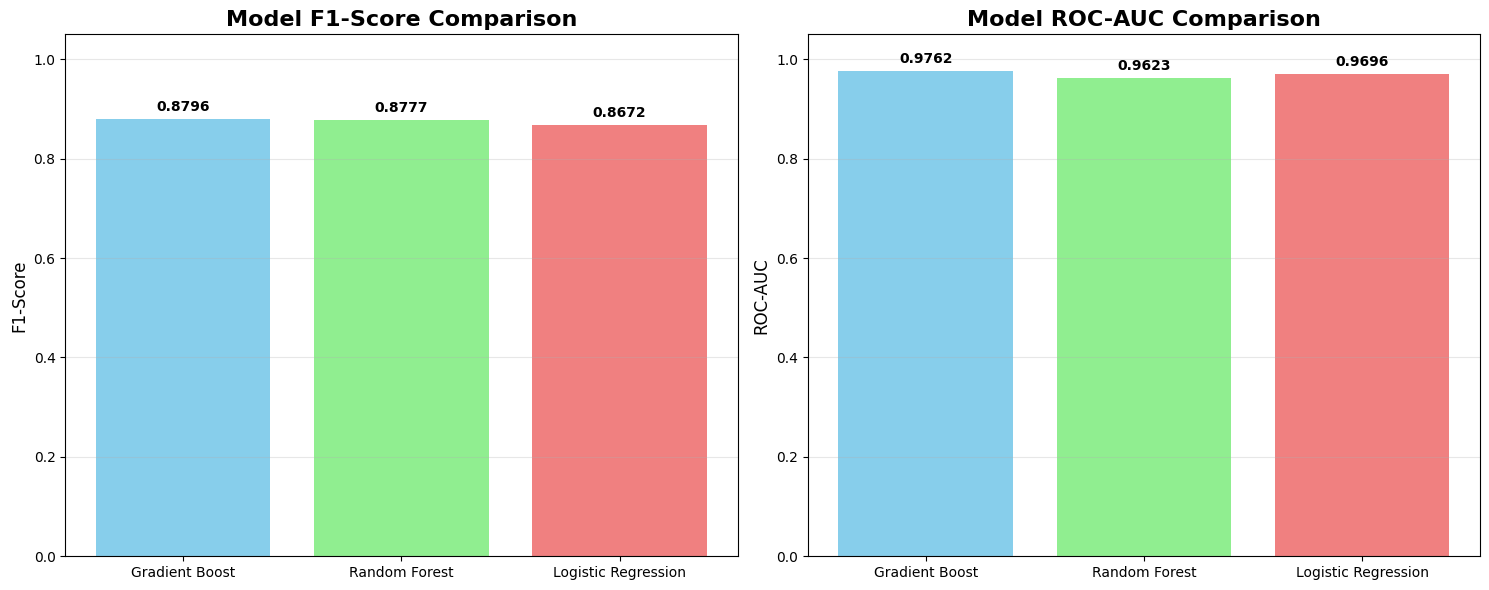

In [22]:
# Convert results dictionary to pandas DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df[['f1_score', 'roc_auc']]  # Select only the metrics we want
results_df = results_df.reset_index().rename(columns={'index': 'Model'})

# Sort by F1-Score (descending)
results_df = results_df.sort_values('f1_score', ascending=False)

print("Model Performance Comparison:")
display(results_df)

# Visualize performance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1-Score comparison
ax1.bar(results_df['Model'], results_df['f1_score'], color=['skyblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Model F1-Score Comparison', fontsize=16, fontweight='bold')
ax1.set_ylabel('F1-Score', fontsize=12)
ax1.set_ylim(0, 1.05)
for i, v in enumerate(results_df['f1_score']):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# ROC-AUC comparison
ax2.bar(results_df['Model'], results_df['roc_auc'], color=['skyblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Model ROC-AUC Comparison', fontsize=16, fontweight='bold')
ax2.set_ylabel('ROC-AUC', fontsize=12)
ax2.set_ylim(0, 1.05)
for i, v in enumerate(results_df['roc_auc']):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

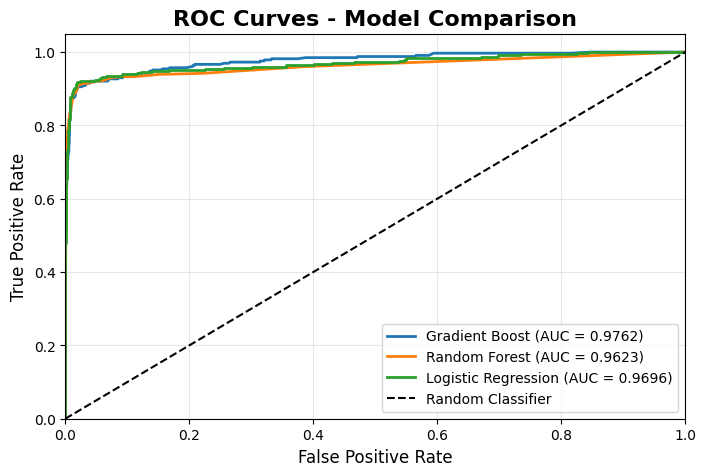

In [23]:
# Plot ROC curves for all models
plt.figure(figsize=(8, 5))

for name in results_df['Model']:
    fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
    roc_auc = results[name]['roc_auc']
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

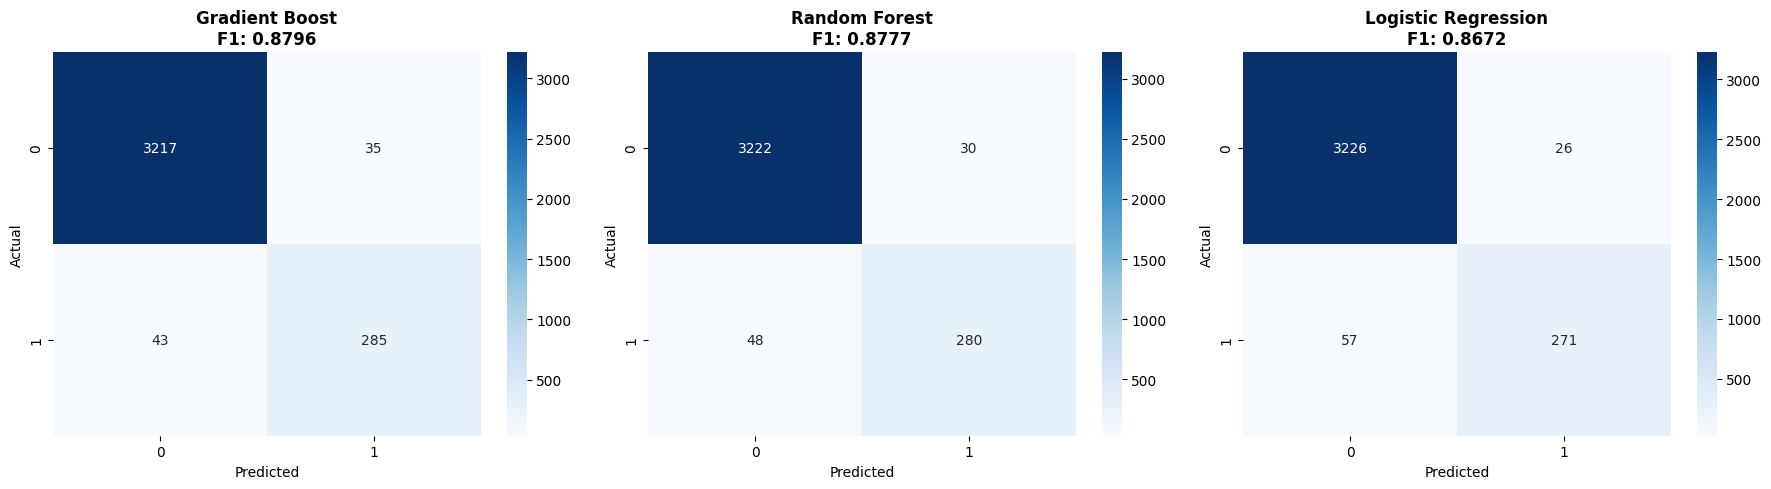

In [24]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, name in enumerate(results_df['Model']):
    cm = confusion_matrix(y_test, results[name]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\nF1: {results[name]["f1_score"]:.4f}', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

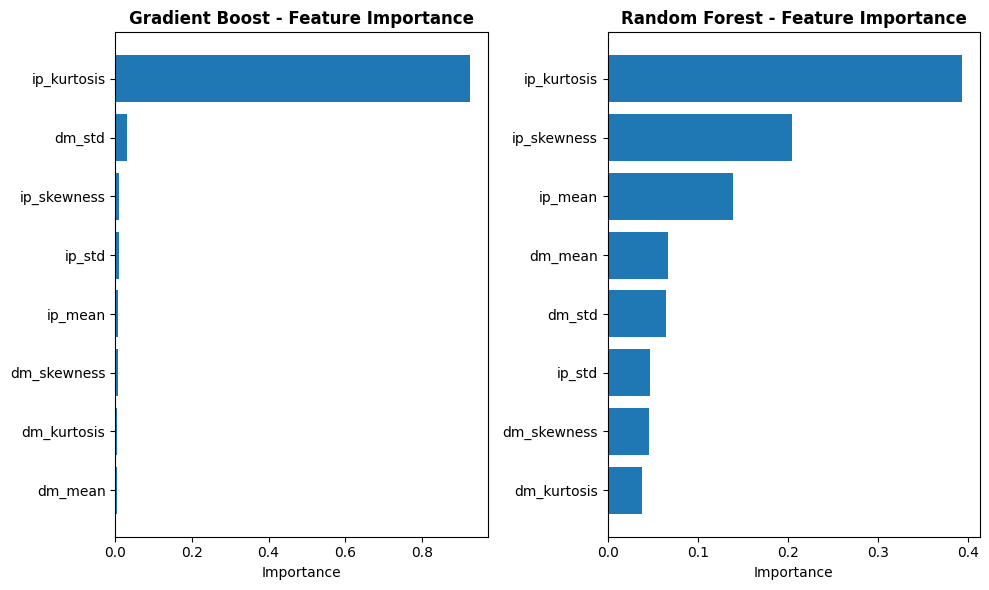

In [25]:
# Plot feature importance for tree-based models
tree_models = results_df[results_df['Model'].isin(['Random Forest', 'Gradient Boost'])]['Model']

if len(tree_models) > 0:
    fig, axes = plt.subplots(1, len(tree_models), figsize=(5*len(tree_models), 6))
    if len(tree_models) == 1:
        axes = [axes]
    
    for idx, name in enumerate(tree_models):
        importance = results[name]['model'].feature_importances_
        feature_names = X.columns
        imp_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
        imp_df = imp_df.sort_values('importance', ascending=True)
        
        axes[idx].barh(imp_df['feature'], imp_df['importance'])
        axes[idx].set_title(f'{name} - Feature Importance', fontweight='bold')
        axes[idx].set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()
else:
    print("No tree-based models to show feature importance for.")

In [26]:
# Create a detailed performance summary using the DataFrame
print("DETAILED PERFORMANCE SUMMARY")
print("="*50)

for _, row in results_df.iterrows():
    name = row['Model']
    print(f"\n{name}:")
    print(f"  F1-Score: {row['f1_score']:.4f}")
    print(f"  ROC-AUC:  {row['roc_auc']:.4f}")
    
    # Additional metrics from classification report
    report = classification_report(y_test, results[name]['predictions'], output_dict=True)
    print(f"  Precision: {report['1']['precision']:.4f}")
    print(f"  Recall:    {report['1']['recall']:.4f}")

DETAILED PERFORMANCE SUMMARY

Gradient Boost:
  F1-Score: 0.8796
  ROC-AUC:  0.9762
  Precision: 0.8906
  Recall:    0.8689

Random Forest:
  F1-Score: 0.8777
  ROC-AUC:  0.9623
  Precision: 0.9032
  Recall:    0.8537

Logistic Regression:
  F1-Score: 0.8672
  ROC-AUC:  0.9696
  Precision: 0.9125
  Recall:    0.8262
